<a href="https://colab.research.google.com/github/Fatima8024/Deep-Learning/blob/main/Detection_of_Fake_News_Text_Classification_on_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Project-1]**
 Detection of Fake News Text Classification on COVID-19 Using Deep Learning Approaches

**Part (a)**

-Apply BERT for text vectorization

-Apply RNN with suitable number of neuron and epoch.


In [ ]:
# Install required libraries
!pip install transformers tensorflow scikit-learn pandas imbalanced-learn

# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from google.colab import files
from imblearn.over_sampling import RandomOverSampler

# Step 1: Load the dataset from your local computer
from google.colab import files

print("Please upload your dataset (CSV format)")
uploaded = files.upload()

# Assuming the uploaded dataset is named `covid19_fake_news.csv`
dataset_name = list(uploaded.keys())[0]
data = pd.read_csv(dataset_name)

# Preprocessing
texts = data['headlines'].tolist()
labels = data['outcome'].tolist()

# Encode labels (0 for fake, 1 for real)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Handle Class Imbalance (using RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(texts).reshape(-1, 1), encoded_labels)
texts = X_resampled.flatten()
encoded_labels = y_resampled

# Step 2: Split the dataset into Training, Validation, and Test sets
# 80% Training, 10% Validation, 10% Test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")
# Step 3: Tokenize and convert text to BERT embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def preprocess_texts(texts, max_len=128):
    """Tokenize and create attention masks."""
    # Convert ndarray to list if necessary
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()  # Convert ndarray to list

    encoded = bert_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return encoded['input_ids'], encoded['attention_mask']

# Tokenize data
train_input_ids, train_attention_masks = preprocess_texts(train_texts)
val_input_ids, val_attention_masks = preprocess_texts(val_texts)
test_input_ids, test_attention_masks = preprocess_texts(test_texts)

# Step 4: Define the Simple RNN-based classifier
def build_model():
    input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    # BERT embeddings
    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(128, 768,)  # Output shape of all hidden states
    )([input_ids, attention_mask])

    # RNN Layer (Simple RNN)
    x = SimpleRNN(128, return_sequences=False)(bert_output)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# Step 5: Train the model
history = model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    batch_size=16,
    epochs=2
)

# Step 6: Evaluate the model and calculate additional metrics
test_loss, test_acc = model.evaluate([test_input_ids, test_attention_masks], test_labels, verbose=0)

# Generate predictions
predictions = model.predict([test_input_ids, test_attention_masks], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

# Calculate Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='binary')
recall = recall_score(true_classes, predicted_classes, average='binary')
f1 = f1_score(true_classes, predicted_classes, average='binary')

# Print warnings if imbalance is suspected
unique_classes, counts = np.unique(predicted_classes, return_counts=True)
print(f"Predicted class distribution: {dict(zip(unique_classes, counts))}")
if len(unique_classes) < 2:
    print("Warning: Model is predicting only one class. This may indicate class imbalance or poor training.")

# Compile all metrics into a dictionary
test_metrics = {
    "Test Loss": test_loss,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

# Print the metrics
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


Please upload your dataset (CSV format)


Saving covid19_fake_news.csv to covid19_fake_news.csv


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training samples: 15563
Validation samples: 1945
Test samples: 1946


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 128)            │        114,816 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ simple_rnn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            130 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 123,202 (481.26 KB)

 Trainable params: 123,202 (481.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
973/973 ━━━━━━━━━━━━━━━━━━━━ 181s 158ms/step - accuracy: 0.6669 - loss: 0.5927 - val_accuracy: 0.9147 - val_loss: 0.2386
Epoch 2/2
973/973 ━━━━━━━━━━━━━━━━━━━━ 170s 137ms/step - accuracy: 0.9066 - loss: 0.2668 - val_accuracy: 0.9383 - val_loss: 0.1791
Predicted class distribution: {0: 982, 1: 964}

Test Metrics:
Test Loss: 0.1809
Test Accuracy: 0.9368
Precision: 0.9409
Recall: 0.9322
F1-Score: 0.9365

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       973
           1       0.94      0.93      0.94       973

    accuracy                           0.94      1946
   macro avg       0.94      0.94      0.94      1946
weighted avg       0.94      0.94      0.94      1946



Complete the Same Task Using LSTM


In [ ]:
# Install required libraries
!pip install transformers tensorflow scikit-learn pandas imbalanced-learn

# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from google.colab import files
from imblearn.over_sampling import RandomOverSampler

# Step 1: Load the dataset from your local computer
print("Please upload your dataset (CSV format)")
uploaded = files.upload()

# Assuming the uploaded dataset is named `covid19_fake_news.csv`
dataset_name = list(uploaded.keys())[0]
data = pd.read_csv(dataset_name)

# Preprocessing
texts = data['headlines'].tolist()
labels = data['outcome'].tolist()

# Encode labels (0 for fake, 1 for real)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Handle Class Imbalance (using RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(texts).reshape(-1, 1), encoded_labels)
texts = X_resampled.flatten()
encoded_labels = y_resampled

# Step 2: Split the dataset into Training, Validation, and Test sets
# 80% Training, 10% Validation, 10% Test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Step 3: Tokenize and convert text to BERT embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def preprocess_texts(texts, max_len=128):
    """Tokenize and create attention masks."""
    # Convert ndarray to list if necessary
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()  # Convert ndarray to list

    encoded = bert_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return encoded['input_ids'], encoded['attention_mask']

# Tokenize data
train_input_ids, train_attention_masks = preprocess_texts(train_texts)
val_input_ids, val_attention_masks = preprocess_texts(val_texts)
test_input_ids, test_attention_masks = preprocess_texts(test_texts)

# Step 4: Define the LSTM-based classifier
def build_model():
    input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    # BERT embeddings
    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(128, 768,)  # Output shape of all hidden states
    )([input_ids, attention_mask])

    # LSTM Layer
    x = LSTM(128, return_sequences=False)(bert_output)  # Changed from SimpleRNN to LSTM
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',  # Ensure labels are integers
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# Step 5: Train the model
history = model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    batch_size=16,
    epochs=2
)

# Step 6: Evaluate the model and calculate additional metrics
test_loss, test_acc = model.evaluate([test_input_ids, test_attention_masks], test_labels, verbose=0)

# Generate predictions
predictions = model.predict([test_input_ids, test_attention_masks], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

# Calculate Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='binary')
recall = recall_score(true_classes, predicted_classes, average='binary')
f1 = f1_score(true_classes, predicted_classes, average='binary')

# Print warnings if imbalance is suspected
unique_classes, counts = np.unique(predicted_classes, return_counts=True)
print(f"Predicted class distribution: {dict(zip(unique_classes, counts))}")
if len(unique_classes) < 2:
    print("Warning: Model is predicting only one class. This may indicate class imbalance or poor training.")

# Compile all metrics into a dictionary
test_metrics = {
    "Test Loss": test_loss,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

# Print the metrics
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


Please upload your dataset (CSV format)


Saving covid19_fake_news.csv to covid19_fake_news (1).csv


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training samples: 15563
Validation samples: 1945
Test samples: 1946


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        459,264 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │            130 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 467,650 (1.78 MB)

 Trainable params: 467,650 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
973/973 ━━━━━━━━━━━━━━━━━━━━ 185s 174ms/step - accuracy: 0.6985 - loss: 0.5522 - val_accuracy: 0.9203 - val_loss: 0.2177
Epoch 2/2
973/973 ━━━━━━━━━━━━━━━━━━━━ 191s 167ms/step - accuracy: 0.9221 - loss: 0.2238 - val_accuracy: 0.9496 - val_loss: 0.1545
Predicted class distribution: {0: 966, 1: 980}

Test Metrics:
Test Loss: 0.1355
Test Accuracy: 0.9553
Precision: 0.9520
Recall: 0.9589
F1-Score: 0.9555

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       973
           1       0.95      0.96      0.96       973

    accuracy                           0.96      1946
   macro avg       0.96      0.96      0.96      1946
weighted avg       0.96      0.96      0.96      1946



**Tabular Details:**


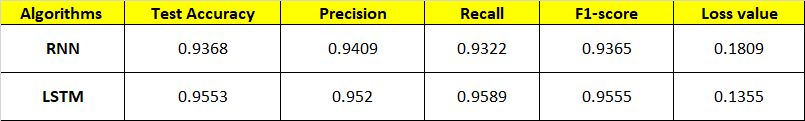

**[Project-1]**
 Detection of Fake News Text Classification on COVID-19 Using Deep Learning Approaches

Part (a)

-Apply text2vec for text vectorization

-Apply RNN with suitable number of neuron and epoch.

In [ ]:
# Install required libraries
!pip install tensorflow scikit-learn pandas imbalanced-learn text2vec

# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from text2vec import SentenceModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Step 1: Load the dataset
from google.colab import files

print("Please upload your dataset (CSV format)")
uploaded = files.upload()

dataset_name = list(uploaded.keys())[0]
data = pd.read_csv(dataset_name)

# Preprocessing
texts = data['headlines'].tolist()
labels = data['outcome'].tolist()

# Encode labels (0 for fake, 1 for real)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
texts_resampled, labels_resampled = ros.fit_resample(
    np.array(texts).reshape(-1, 1), encoded_labels
)
texts = texts_resampled.flatten()
encoded_labels = labels_resampled
categorical_labels = to_categorical(encoded_labels)

# Step 2: Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Step 3: Use text2vec for vectorization
sentence_model = SentenceModel("sentence-transformers/all-MiniLM-L6-v2")

def vectorize_texts(texts):
    """
    Converts text into embeddings using the sentence model.
    """
    return sentence_model.encode(texts)

# Vectorize data
train_vectors = vectorize_texts(train_texts)
val_vectors = vectorize_texts(val_texts)
test_vectors = vectorize_texts(test_texts)

# Step 4: Define the RNN-based model
# Step 4: Define the RNN-based model
def build_model(input_shape):
    inputs = Input(shape=(input_shape,), dtype=tf.float32, name="input_vectors")

    # Reshape the input to add a timestep dimension
    # The new shape will be (batch_size, 1, input_shape)
    # This assumes each sentence is a single timestep sequence
    x = tf.keras.layers.Reshape((1, input_shape))(inputs)

    # RNN Layer
    x = SimpleRNN(128, return_sequences=False)(x)  # Pass the reshaped input
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
input_shape = train_vectors.shape[1]
model = build_model(input_shape)
model.summary()

# Step 5: Train the model
history = model.fit(
    train_vectors,
    train_labels,
    validation_data=(val_vectors, val_labels),
    batch_size=16,
    epochs=10
)

# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(test_vectors, test_labels, verbose=0)

# Predictions
predictions = model.predict(test_vectors, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Metrics
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

test_metrics = {
    "Test Loss": test_loss,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

# Print metrics
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
  Created wheel for text2vec: filename=text2vec-1.3.1-py3-none-any.whl size=73544 sha256=b4e3e889ae4f16cf47ddf00b344212c8c885c54248dd9652d4e581264cb34bb9
  Stored in directory: /root/.cache/pip/wheels/1b/5e/90/d280d4ef9741f7ca3adf0987f4c4d96917fe640e3a421d0e48
Successfully built text2vec
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024

Saving covid19_fake_news.csv to covid19_fake_news.csv


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your sessio

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

2024-12-22 17:37:23.821 | DEBUG    | text2vec.sentence_model:__init__:78 - Use pytorch device: cuda


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_vectors (InputLayer)           │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,050 (289.26 KB)

 Trainable params: 74,050 (289.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5766 - loss: 0.6791 - val_accuracy: 0.8015 - val_loss: 0.5042
Epoch 2/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7821 - loss: 0.4937 - val_accuracy: 0.8524 - val_loss: 0.3823
Epoch 3/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8395 - loss: 0.3874 - val_accuracy: 0.8643 - val_loss: 0.3228
Epoch 4/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8553 - loss: 0.3406 - val_accuracy: 0.8797 - val_loss: 0.2905
Epoch 5/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8732 - loss: 0.3085 - val_accuracy: 0.8869 - val_loss: 0.2685
Epoch 6/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8830 - loss: 0.2839 - val_accuracy: 0.8925 - val_loss: 0.2529
Epoch 7/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8862 - loss: 0.2694 - val_accuracy: 0.8972 - val_loss: 0.2415
Epoch 8/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8966 - loss: 0.2518 - val_accuracy: 0

Complete the Same Task Using LSTM

In [ ]:
# Install required libraries
!pip install tensorflow scikit-learn pandas imbalanced-learn text2vec

# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from text2vec import SentenceModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Step 1: Load the dataset
from google.colab import files

print("Please upload your dataset (CSV format)")
uploaded = files.upload()

dataset_name = list(uploaded.keys())[0]
data = pd.read_csv(dataset_name)

# Preprocessing
texts = data['headlines'].tolist()
labels = data['outcome'].tolist()

# Encode labels (0 for fake, 1 for real)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
texts_resampled, labels_resampled = ros.fit_resample(
    np.array(texts).reshape(-1, 1), encoded_labels
)
texts = texts_resampled.flatten()
encoded_labels = labels_resampled
categorical_labels = to_categorical(encoded_labels)

# Step 2: Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Step 3: Use text2vec for vectorization
sentence_model = SentenceModel("sentence-transformers/all-MiniLM-L6-v2")

def vectorize_texts(texts):
    """
    Converts text into embeddings using the sentence model.
    """
    return sentence_model.encode(texts)

# Vectorize data
train_vectors = vectorize_texts(train_texts)
val_vectors = vectorize_texts(val_texts)
test_vectors = vectorize_texts(test_texts)

# Step 4: Define the LSTM-based classifier
def build_model(input_shape):
    inputs = Input(shape=(input_shape,), dtype=tf.float32, name="input_vectors")

    # Reshape the input to add a timestep dimension for LSTM
    x = tf.keras.layers.Reshape((1, input_shape))(inputs)

    # LSTM Layer
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
input_shape = train_vectors.shape[1]
model = build_model(input_shape)
model.summary()

# Step 5: Train the model
history = model.fit(
    train_vectors,
    train_labels,
    validation_data=(val_vectors, val_labels),
    batch_size=16,
    epochs=10
)

# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(test_vectors, test_labels, verbose=0)

# Predictions
predictions = model.predict(test_vectors, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Metrics
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

test_metrics = {
    "Test Loss": test_loss,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

# Print metrics
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))

Please upload your dataset (CSV format)


Saving covid19_fake_news.csv to covid19_fake_news (1).csv


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
2024-12-22 17:56:23.076 | DEBUG    | text2vec.sentence_model:__init__:78 - Use pytorch device: cuda


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_vectors (InputLayer)           │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,042 (1.03 MB)

 Trainable params: 271,042 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6234 - loss: 0.6702 - val_accuracy: 0.8134 - val_loss: 0.5503
Epoch 2/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8197 - loss: 0.5050 - val_accuracy: 0.8530 - val_loss: 0.3867
Epoch 3/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8538 - loss: 0.3739 - val_accuracy: 0.8761 - val_loss: 0.3188
Epoch 4/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8740 - loss: 0.3172 - val_accuracy: 0.8931 - val_loss: 0.2840
Epoch 5/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8852 - loss: 0.2842 - val_accuracy: 0.9023 - val_loss: 0.2607
Epoch 6/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8962 - loss: 0.2647 - val_accuracy: 0.9075 - val_loss: 0.2441
Epoch 7/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9003 - loss: 0.2535 - val_accuracy: 0.9121 - val_loss: 0.2317
Epoch 8/10
973/973 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9103 - loss: 0.2337 - val_accuracy: 

**Tabular Details**


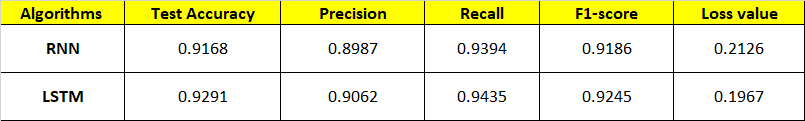

Sample text